In [1]:
import os
import re
import torch
import numpy as np
import tifffile as tiff
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.transforms.v2.functional import normalize

In [ ]:
def normalize_tensor(x):
    """Pass-through because inputs are already normalized upstream."""
    return x


In [9]:

from google.colab import drive
drive.mount('/content/drive') # Mount Google Drive
path = "/content/drive/MyDrive/Colab Notebooks/Sen2MTC_Mini_3v1_norm.pt"
data = torch.load(path, map_location="cpu")

class PrecomputedSen2MTC(Dataset):
    def __init__(self, data_list):
        # data_list is a list of dicts:
        # [{"cloudy_seq": tensor, "clean": tensor}, ...]
        self.data = data_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            "cloudy_seq": item["cloudy_seq"],
            "clean": item["clean"]
        }

def collate_mt(batch):
    # batch: list of {"cloudy_seq":..., "clean":...}

    cloudy = [b["cloudy_seq"] for b in batch]   # list of (T,C,H,W)
    clean  = [b["clean"]      for b in batch]   # list of (C,H,W)

    cloudy = torch.stack(cloudy, dim=0)    # (B,T,C,H,W)
    clean  = torch.stack(clean,  dim=0)    # (B,C,H,W)

    return {
        "cloudy_seq": cloudy,
        "clean": clean
    }


train_set = PrecomputedSen2MTC(data["train"])
val_set   = PrecomputedSen2MTC(data["val"])
test_set  = PrecomputedSen2MTC(data["test"])

train_loader = DataLoader(train_set, batch_size=16,
                          shuffle=True, collate_fn=collate_mt)

val_loader   = DataLoader(val_set,   batch_size=16,
                          shuffle=False, collate_fn=collate_mt)

test_loader  = DataLoader(test_set,  batch_size=16,
                          shuffle=False, collate_fn=collate_mt)


batch = next(iter(train_loader))

print(batch["cloudy_seq"].shape)   # (B,T,C,H,W)
print(batch["clean"].shape)        # (B,C,H,W)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
torch.Size([16, 3, 4, 128, 128])
torch.Size([16, 4, 128, 128])


Multiencoder (3 versus 1)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class MultiTemporalCloudEncoder(nn.Module):
    """
    Wraps a single-image CloudEncoder to handle a sequence of T cloudy images with
    a learned temporal fusion to reduce hallucination risk.

    Input:
        cloudy_seq: (B, T, C, H, W)
    Output:
        feat_agg: (B, C_deep, H_d, W_d)   # aggregated spatial features
        z_agg:    (B, latent_dim)        # aggregated global vector
    """
    def __init__(self, base_encoder: CloudEncoder, T: int = 3):
        super().__init__()
        self.base_encoder = base_encoder
        self.T = T

        # Small MLP to score each timestep using the latent vector
        lat_dim = getattr(base_encoder, 'latent_dim', 128)
        hidden = max(lat_dim // 2, 32)
        self.score_mlp = nn.Sequential(
            nn.Linear(lat_dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, cloudy_seq: torch.Tensor):
        B, T, C, H, W = cloudy_seq.shape
        assert T == self.T, f"Expected T={self.T}, got {T}"

        # (B,T,C,H,W) -> (B*T,C,H,W)
        x_flat = cloudy_seq.view(B * T, C, H, W)

        # apply your existing single-image encoder
        feat_flat, z_flat = self.base_encoder(x_flat)
        # feat_flat: (B*T, C_deep, H_d, W_d)
        # z_flat:    (B*T, latent_dim)

        C_deep = feat_flat.shape[1]
        H_d    = feat_flat.shape[2]
        W_d    = feat_flat.shape[3]
        latent_dim = z_flat.shape[1]

        # reshape back to (B,T,...)
        feat = feat_flat.view(B, T, C_deep, H_d, W_d)
        z    = z_flat.view(B, T, latent_dim)

        # learned temporal weights from z
        scores = self.score_mlp(z)                 # (B,T,1)
        weights = F.softmax(scores, dim=1)         # (B,T,1)

        # weighted aggregation
        w_feat = weights.view(B, T, 1, 1, 1)
        feat_agg = (w_feat * feat).sum(dim=1)      # (B, C_deep, H_d, W_d)
        w_z = weights                               # (B,T,1)
        z_agg = (w_z * z).sum(dim=1)               # (B, latent_dim)

        return feat_agg, z_agg


In [14]:
for batch in train_loader:
    print(batch['cloudy_seq'].shape)
    print(batch['clean'].shape)

    break
#[batch_size, channels, height, width] -> [batch_size, channels, patch_size, patch_size]

torch.Size([16, 3, 4, 128, 128])
torch.Size([16, 4, 128, 128])


In [15]:
import torch.nn as nn
import torch.nn.functional as F

# structure ok
class ResidualBlock(nn.Module):
    """
    Small residual conv block:
    in -> Conv -> GN -> SiLU -> Conv -> GN -> +skip
    """
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.gn1   = nn.GroupNorm(num_groups=min(num_groups, out_channels), num_channels=out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.gn2   = nn.GroupNorm(num_groups=min(num_groups, out_channels), num_channels=out_channels)
        self.silu   = nn.SiLU(inplace=True)

        # if channel dims change, use 1*1 conv for skip
        if in_channels != out_channels:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        identity = self.skip(x)
        out = self.conv1(x)
        out = self.gn1(out)
        out = self.silu(out)
        out = self.conv2(out)
        out = self.gn2(out)
        out = out + identity
        out = self.silu(out)
        return out

class CloudEncoder(nn.Module):
    """
    Cloud encoder based on CNN.

    Input:
        x: (B, in_channels, H, W), normalize required

    Output:
        feat: (B, C_lowres, H_down, W_down)  spatial cloud features
        z:    (B, latent_dim)               global embedding
    """
    def __init__(
        self,
        in_channels = 4,
        base_channels = 32,
        num_stages = 3,
        latent_dim = 128,
        num_groups = 8,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.base_channels = base_channels
        self.num_stages = num_stages
        self.latent_dim = latent_dim

        layers = []

        # Initial conv to get to base_channels
        layers.append(
            nn.Sequential(
                nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1),
                nn.GroupNorm(num_groups=min(num_groups, base_channels), num_channels=base_channels),
                nn.SiLU(inplace=True),
            )
        )

        in_ch = base_channels
        channels = [base_channels * (2 ** i) for i in range(num_stages)]

        # Residual + downsample stages
        self.down_blocks = nn.ModuleList()
        self.downsamples = nn.ModuleList()

        for out_ch in channels:
            self.down_blocks.append(ResidualBlock(in_ch, out_ch, num_groups=num_groups))
            # stride-2 conv for downsampling
            self.downsamples.append(
                nn.Conv2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
            )
            in_ch = out_ch

        # A final residual block at lowest resolution
        self.final_block = ResidualBlock(in_ch, in_ch, num_groups=num_groups)

        # Register first stem as single module for clarity
        self.stem = layers[0]

        # Projection to latent space
        self.proj = nn.Linear(in_ch, latent_dim)

    def forward(self, x: torch.Tensor):
        """
        x: (B, C, H, W)

        returns:
            feat: (B, C_final, H_down, W_down)  spatial feature map
            z:    (B, latent_dim)               global vector
        """
        # Stem
        h = self.stem(x)  # (B, base_channels, H, W)

        # Downsampling stages
        for block, down in zip(self.down_blocks, self.downsamples):
            h = block(h)
            h = down(h)  # spatial size halves each time

        # Final block
        h = self.final_block(h)

        # 1) spatial feature map (we keep it as-is)
        feat = h  # (B, C_final, H_down, W_down)

        # 2) global average pooling -> vector
        pooled = F.adaptive_avg_pool2d(h, output_size=1).squeeze(-1).squeeze(-1)

        # 3) project to latent_dim
        z = self.proj(pooled)  # (B, latent_dim)

        return feat, z


In [16]:
class ForwardDiffusion_traditional(nn.Module):
    """
    Standard DDPM-style forward diffusion on CLEAN only,
    but keeps the (clean, cloudy, t) signature for compatibility.
    """
    def __init__(self, T=500, beta_start=1e-4, beta_end=0.02):
        super().__init__()
        self.T = T

        betas = torch.linspace(beta_start, beta_end, T)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)

    def sample_t(self, batch_size, device):
        return torch.randint(0, self.T, (batch_size,), device=device)

    def forward(self, clean, cloudy, t):
        """
        clean:  (B, C, H, W)
        cloudy: unused, kept only for API compatibility
        t:      (B,) integer timesteps
        """
        B = clean.shape[0]
        noise = torch.randn_like(clean)

        alpha_bar_t = self.alphas_cumprod[t].view(B, 1, 1, 1)
        x_t = torch.sqrt(alpha_bar_t) * clean + torch.sqrt(1 - alpha_bar_t) * noise
        return x_t, noise, None  # mu_t not used anymore


class ForwardDiffusion(nn.Module):
    """
    Liu-style forward:
        x_t = (1-位_t)*clean + 位_t*cloudy + 蟽_t * 蔚
    """
    def __init__(self, T=500, sigma_min=0.01, sigma_max=0.4):
        super().__init__()
        self.T = T

        sigmas = torch.linspace(sigma_min, sigma_max, T)
        lambdas = torch.linspace(0.0, 1.0, T)

        self.register_buffer("sigmas", sigmas)     # (T,)
        self.register_buffer("lambdas", lambdas)   # (T,)

    def sample_t(self, batch_size, device):
        return torch.randint(0, self.T, (batch_size,), device=device)

    def forward(self, clean, cloudy, t):
        """
        clean, cloudy: (B,C,H,W)
        t: (B,) int timesteps
        Returns:
            x_t:  noisy sample
            eps:  noise used
            mu_t: clean/cloudy mean BEFORE noise
        """
        B = clean.shape[0]
        eps = torch.randn_like(clean)

        sigma_t  = self.sigmas[t].view(B, 1, 1, 1)
        lambda_t = self.lambdas[t].view(B, 1, 1, 1)

        mu_t = (1.0 - lambda_t) * clean + lambda_t * cloudy
        x_t  = mu_t + sigma_t * eps

        return x_t, eps, mu_t

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# ---------------------------------------------------------------------
# 1. Simple sinusoidal timestep embedding
# ---------------------------------------------------------------------
def timestep_embedding(t, dim):
    half = dim // 2
    freqs = torch.exp(
        torch.arange(half, dtype=torch.float32, device=t.device)
        * (-torch.log(torch.tensor(10000.0)) / (half - 1))
    )
    args = t[:, None].float() * freqs[None]
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    return emb


# ---------------------------------------------------------------------
# 2. Basic ResNet block (Conv-Norm-Act-Conv-Norm-Act)
# ---------------------------------------------------------------------
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, cond_dim):
        super().__init__()
        self.time_dense = nn.Linear(time_emb_dim, out_ch)
        self.cond_dense = nn.Linear(cond_dim, out_ch)

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act = nn.SiLU()

        self.shortcut = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb, c_emb):
        """
        x:     (B, C, H, W)
        t_emb: (B, time_emb_dim)
        c_emb: (B, cond_dim)
        """
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act(h)

        t_added = self.time_dense(t_emb)[:, :, None, None]
        c_added = self.cond_dense(c_emb)[:, :, None, None]
        h = h + t_added + c_added

        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act(h)

        return h + self.shortcut(x)



# ---------------------------------------------------------------------
# 3. Minimal UNet for 4 channel diffusion
# ---------------------------------------------------------------------
class SmallUNet4C(nn.Module):
    def __init__(
        self,
        in_channels=4,
        out_channels=4,
        base_channels=64,
        time_emb_dim=256,
        cond_dim=128,
        max_T=750
    ):
        super().__init__()
        self.max_T = max_T
        # time embedding MLP
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # cloud embedding MLP
        self.cond_mlp = nn.Sequential(
            nn.Linear(cond_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # ---------- Down ----------
        self.conv_in = nn.Conv2d(in_channels, base_channels, 3, padding=1)

        self.down1 = ResBlock(base_channels, base_channels * 2, time_emb_dim, time_emb_dim)
        self.down2 = ResBlock(base_channels * 2, base_channels * 4, time_emb_dim, time_emb_dim)

        self.pool = nn.MaxPool2d(2)

        # ---------- Middle ----------
        self.mid = ResBlock(base_channels * 4, base_channels * 4, time_emb_dim, time_emb_dim)

        # ---------- Up ----------
        self.up1 = ResBlock(base_channels * 4 + base_channels * 4, base_channels * 2, time_emb_dim, time_emb_dim)
        self.up2 = ResBlock(base_channels * 2 + base_channels * 2, base_channels, time_emb_dim, time_emb_dim)

        self.conv_out = nn.Conv2d(base_channels, out_channels, 3, padding=1)

    def forward(self, x, t, z_cloud):
        # t: (B,)
        if t.ndim == 0:
            t = t.unsqueeze(0)

        t = t.float() / (self.max_T - 1)     # normalize to [0,1]
        t_emb = timestep_embedding(t, self.time_mlp[0].in_features)
        t_emb = self.time_mlp(t_emb)

        c_emb = self.cond_mlp(z_cloud)

        # Down
        x1 = self.conv_in(x)
        x2 = self.down1(x1, t_emb, c_emb)
        x3 = self.pool(x2)
        x3 = self.down2(x3, t_emb, c_emb)

        # Middle
        xm = self.mid(x3, t_emb, c_emb)

        # Up
        u1 = torch.cat([xm, x3], dim=1)
        u1 = self.up1(u1, t_emb, c_emb)

        u2 = F.interpolate(u1, scale_factor=2, mode="nearest")
        u2 = torch.cat([u2, x2], dim=1)
        u2 = self.up2(u2, t_emb, c_emb)

        out = self.conv_out(u2)
        return out


class CloudConditionedUNet_4C(nn.Module):
    def __init__(self, in_channels=4, out_channels=4, latent_dim=128, max_T=750):
        super().__init__()

        self.unet = SmallUNet4C(
            in_channels=in_channels,
            out_channels=out_channels,
            cond_dim=latent_dim,
            max_T=max_T
        )

    def forward(self, x_t, t, z_cloud):
        eps_pred = self.unet(x_t, t, z_cloud)
        return eps_pred


In [ ]:
New thing

In [18]:
def edm_preconditioning(sigma, sigma_data=1.0):
    """
    Given noise level sigma (shape [B]), compute EDM-style
    preconditioning coefficients.

    Returns:
        c_in, c_skip, c_out, c_noise
    each broadcastable to image tensors.
    """
    # make sure sigma has shape [B, 1, 1, 1]
    if sigma.ndim == 1:
        sigma = sigma.view(-1, 1, 1, 1)

    sigma2 = sigma ** 2
    sd2 = sigma_data ** 2

    # input scaling
    c_in = 1.0 / torch.sqrt(sd2 + sigma2)

    # skip connection weight
    c_skip = sd2 / (sd2 + sigma2)

    # output scaling
    c_out = (sigma * sigma_data) / torch.sqrt(sd2 + sigma2)

    # extra noise embedding (optional, for a small MLP)
    c_noise = 0.25 * torch.log(sigma)

    return c_in, c_skip, c_out, c_noise


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# base encoder config
in_channels = 4
base_channels = 32
num_stages = 2
latent_dim = 128

base_encoder = CloudEncoder(
    in_channels=in_channels,
    base_channels=base_channels,
    num_stages=num_stages,   # or 3, whatever you used
    latent_dim=latent_dim
).to(device)

cloud_encoder = MultiTemporalCloudEncoder(base_encoder, T=3).to(device)
forwarder = ForwardDiffusion(T=750).to(device)

# Feature channels after encoder final block
feat_channels = base_channels * (2 ** (num_stages - 1))  # e.g., 64 for num_stages=2
# F_in channels: 4 noisy + 3*4 cloudy sequence + feat_channels
f_in_channels = 4 + 3 * in_channels + feat_channels

# We keep out_channels=4 for noise prediction

denoiser = CloudConditionedUNet_4C(
    in_channels=f_in_channels,
    out_channels=4,
    latent_dim=latent_dim,
    max_T=750
).to(device)

loss_fn = torch.nn.MSELoss()
params = list(cloud_encoder.parameters()) + list(denoiser.parameters())
optimizer = torch.optim.Adam(params, lr=1e-4)
epochs = 7


In [21]:
import torch.nn.functional as F




def forward_trainer(epochs, train_loader, loss_fn, optimizer,
                    forwarder, cloud_encoder, denoiser, device):
    cloud_encoder.train()
    denoiser.train()

    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0

        for batch in train_loader:
            cloudy_seq = batch['cloudy_seq'].to(device)   # (B,3,4,H,W)
            clean      = batch['clean'].to(device)        # (B,4,H,W)
            B = cloudy_seq.shape[0]

            cloudy_ref = cloudy_seq[:, 0]                                  # (B,4,H,W)

            feat_agg, z_agg = cloud_encoder(cloudy_seq)                     # feat_agg: (B,Cd,Hd,Wd)

            feat_up = F.interpolate(
                feat_agg,
                size=cloudy_ref.shape[-2:],
                mode='bilinear',
                align_corners=False,
            )

            cloudy_seq_flat = cloudy_seq.view(B, -1, cloudy_seq.shape[-2], cloudy_seq.shape[-1])

            t = forwarder.sample_t(B, device=device)
            x_t, eps, mu_t = forwarder(clean, cloudy_ref, t)

            sigma = forwarder.sigmas[t].to(device)       # (B,)

            c_in, c_skip, c_out, c_noise = edm_preconditioning(
                sigma, sigma_data=1.0
            )

            x_t_scaled = c_in * x_t

            # F_in: noisy + full cloudy sequence + upsampled features
            F_in = torch.cat([x_t_scaled, cloudy_seq_flat, feat_up], dim=1)  # (B,?,H,W)
            assert F_in.shape[1] == denoiser.unet.conv_in.in_channels,                 f"F_in channels {F_in.shape[1]} != denoiser expects {denoiser.unet.conv_in.in_channels}. Rerun cell 12 to reinit denoiser."

            F_out = denoiser(F_in, t, z_agg)

            pred_x0 = c_skip * x_t + c_out * F_out

            lambda_sigma = 1.0 / (c_out ** 2 + 1e-8)
            loss = (lambda_sigma * (pred_x0 - clean) ** 2).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        print(f"[Epoch {epoch+1}] loss = {avg_loss:.6f}")


forward_trainer(epochs, train_loader, loss_fn, optimizer,
                forwarder, cloud_encoder, denoiser, device)


[Epoch 1] loss = 1.918605
[Epoch 2] loss = 1.333804
[Epoch 3] loss = 1.102377
[Epoch 4] loss = 0.694216
[Epoch 5] loss = 0.554668
[Epoch 6] loss = 0.481393
[Epoch 7] loss = 0.434278


In [22]:
torch.save(cloud_encoder.state_dict(), './cloud_enc_7e_MiniData_forward refined.pth')
torch.save(denoiser.state_dict(), './denoiser_7e_MiniData_forward refined.pth')

In [23]:
@torch.no_grad()
def sampler(
    cloudy_seq: torch.Tensor,
    cloud_encoder,
    denoiser,
    forwarder,
    num_steps: int = 100,
    device=None,
):
    if device is None:
        device = cloudy_seq.device
    cloudy_seq = normalize_tensor(cloudy_seq.to(device))   # (B,3,4,H,W)
    B, T, C, H, W = cloudy_seq.shape

    cloudy_ref = cloudy_seq[:, 0]                          # use first frame
    cloud_feat, z_cloud = cloud_encoder(cloudy_seq)
    feat_up = F.interpolate(
        cloud_feat,
        size=(H, W),
        mode='bilinear',
        align_corners=False,
    )
    cloudy_seq_flat = cloudy_seq.view(B, -1, H, W)         # (B,12,H,W)

    times = torch.linspace(forwarder.T - 1, 0, steps=num_steps + 1, device=device).long()

    t_start = times[0]
    sigma_start = forwarder.sigmas[t_start].view(1, 1, 1, 1).to(device)
    x_t = cloudy_ref + sigma_start * torch.randn_like(cloudy_ref)

    for i in range(num_steps):
        t_now = times[i]
        t_next = times[i + 1]

        lambda_now = forwarder.lambdas[t_now].view(1, 1, 1, 1).to(device)
        lambda_next = forwarder.lambdas[t_next].view(1, 1, 1, 1).to(device)

        sigma_now = forwarder.sigmas[t_now].to(device)
        sigma_next = forwarder.sigmas[t_next].to(device)

        c_in, c_skip, c_out, c_noise = edm_preconditioning(
            sigma_now.expand(B), sigma_data=1.0
        )

        x_t_scaled = c_in * x_t
        F_in = torch.cat([x_t_scaled, cloudy_seq_flat, feat_up], dim=1)  # (B,?,H,W)
        assert F_in.shape[1] == denoiser.unet.conv_in.in_channels,             f"F_in channels {F_in.shape[1]} != denoiser expects {denoiser.unet.conv_in.in_channels}. Rerun cell 12 to reinit denoiser."

        t_batch = t_now.expand(B)
        F_out = denoiser(F_in, t_batch, z_cloud)        # (B,4,H,W)

        x0_pred = c_skip * x_t + c_out * F_out          # (B,4,H,W)

        mu_now  = (1.0 - lambda_now)  * x0_pred + lambda_now  * cloudy_ref
        mu_next = (1.0 - lambda_next) * x0_pred + lambda_next * cloudy_ref

        deviation = x_t - mu_now
        noise_scale = sigma_next / (sigma_now + 1e-8)

        x_t = mu_next + noise_scale * deviation

    return x_t


In [24]:
cloud_encoder.eval()
denoiser.eval()

batch = next(iter(val_loader))
cloudy_seq = batch['cloudy_seq'].to(device)   # (B,3,4,H,W)

x0 = sampler(
    cloudy_seq=cloudy_seq,
    cloud_encoder=cloud_encoder,
    denoiser=denoiser,
    forwarder=forwarder,
    num_steps=750
)

print(x0.shape)


NameError: name 'mean' is not defined

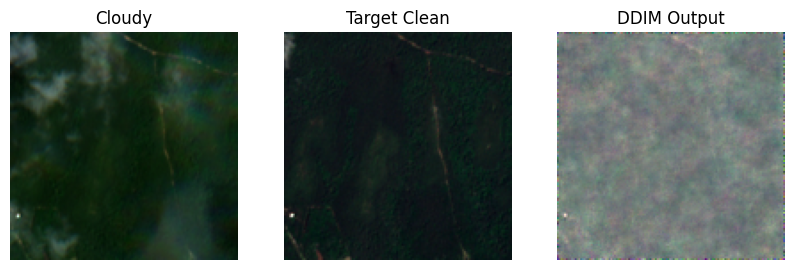

In [45]:
import matplotlib.pyplot as plt

def to_vis(img):
    # Accepts (4,H,W) or (3,H,W); if (T,4,H,W) take mean over time
    if img.ndim == 4:
        img = img.mean(dim=0)
    if img.ndim != 3:
        raise ValueError(f"Expected 3 dims after squeeze, got {img.ndim}")
    x = img[:3].detach().cpu().numpy()
    x = x.transpose(1,2,0)  # (H,W,C)
    x = x - x.min()
    x = x / (x.max() + 1e-6)
    return x

i = 0
cloudy_vis = to_vis(cloudy_seq[i])            # uses temporal mean if 4D
clean_vis  = to_vis(batch["clean"][i])
x0_vis     = to_vis(x0[i])

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.title("Cloudy"); plt.imshow(cloudy_vis); plt.axis("off")
plt.subplot(1,3,2); plt.title("Target Clean"); plt.imshow(clean_vis); plt.axis("off")
plt.subplot(1,3,3); plt.title("DDIM Output"); plt.imshow(x0_vis); plt.axis("off")
plt.show()


In [ ]:
@torch.no_grad()
def inspect_forward_process(clean, cloudy, forwarder, num_steps=10):
    clean = normalize_tensor(clean)
    cloudy = normalize_tensor(cloudy)
    device = clean.device
    B, C, H, W = clean.shape

    out = {
        'x_t_list': [],
        'eps_list': [],
        'mu_t_list': [],
        't_list': []
    }

    T = forwarder.T
    t_values = torch.linspace(0, T-1, num_steps, device=device).long()

    for t in t_values:
        t_batch = t.expand(B)

        x_t, eps, mu_t = forwarder(clean, cloudy, t_batch)

        out['x_t_list'].append(x_t)
        out['eps_list'].append(eps)
        out['mu_t_list'].append(mu_t)
        out['t_list'].append(int(t.item()))

    return out


In [ ]:
batch = next(iter(train_loader))
clean  = normalize_tensor(batch['clean'].to(device))
cloudy = normalize_tensor(batch['cloudy'].to(device))

forwarder = ForwardDiffusion(T=750).to(device)
forward_info = inspect_forward_process(clean, cloudy, forwarder, num_steps=8)

for i, t in enumerate(forward_info['t_list']):
    print(f"t = {t}")
    print('  mean(abs(x_t)) =', forward_info['x_t_list'][i].abs().mean().item())
    print('  mean(abs(mu_t)) =', forward_info['mu_t_list'][i].abs().mean().item())


t = 0
  mean(abs(x_t)) = 0.6594529151916504
  mean(abs(mu_t)) = 0.6594465374946594
t = 107
  mean(abs(x_t)) = 0.5721580982208252
  mean(abs(mu_t)) = 0.5711017847061157
t = 214
  mean(abs(x_t)) = 0.5333855152130127
  mean(abs(mu_t)) = 0.5276200771331787
t = 321
  mean(abs(x_t)) = 0.557843029499054
  mean(abs(mu_t)) = 0.5468084812164307
t = 428
  mean(abs(x_t)) = 0.6127500534057617
  mean(abs(mu_t)) = 0.5949603319168091
t = 535
  mean(abs(x_t)) = 0.6830354332923889
  mean(abs(mu_t)) = 0.6568719744682312
t = 642
  mean(abs(x_t)) = 0.7646292448043823
  mean(abs(mu_t)) = 0.726260781288147
t = 749
  mean(abs(x_t)) = 0.8532615303993225
  mean(abs(mu_t)) = 0.8004270195960999


In [ ]:
@torch.no_grad()
def inspect_reverse_process(
    cloudy_seq, cloud_encoder, denoiser, forwarder, num_steps=50
):
    cloudy_seq = normalize_tensor(cloudy_seq)
    device = cloudy_seq.device
    B, T, C, H, W = cloudy_seq.shape

    sigmas = forwarder.sigmas
    lambdas = forwarder.lambdas
    T_total = forwarder.T

    step_indices = torch.linspace(T_total - 1, 0, num_steps, device=device).long()

    out = {
        'x_t_list': [],
        'eps_pred_list': [],
        'mu_t_list': [],
        'mu_prev_list': [],
        't_list': []
    }

    cloudy_ref = cloudy_seq[:, 0]                              # first frame
    cloudy_seq_flat = cloudy_seq.view(B, -1, H, W)              # (B,12,H,W)
    cloud_feat, z_cloud = cloud_encoder(cloudy_seq)
    feat_up = F.interpolate(cloud_feat, size=(H, W), mode='bilinear', align_corners=False)

    t0 = step_indices[0]
    sigma0 = sigmas[t0].view(1,1,1,1).to(device)
    x_t = cloudy_ref + sigma0 * torch.randn_like(cloudy_ref)

    for i in range(num_steps - 1):
        t_now = step_indices[i]
        t_next = step_indices[i+1]

        x_current = x_t

        sigma_now = sigmas[t_now]
        sigma_next = sigmas[t_next]

        lambda_now = lambdas[t_now].view(1,1,1,1)
        lambda_next = lambdas[t_next].view(1,1,1,1)

        c_in, c_skip, c_out, c_noise = edm_preconditioning(sigma_now.expand(B), sigma_data=1.0)
        x_t_scaled = c_in * x_current
        F_in = torch.cat([x_t_scaled, cloudy_seq_flat, feat_up], dim=1)
        assert F_in.shape[1] == denoiser.unet.conv_in.in_channels,             f"F_in channels {F_in.shape[1]} != denoiser expects {denoiser.unet.conv_in.in_channels}. Rerun cell 12 to reinit denoiser."

        F_out = denoiser(F_in, t_now.expand(B), z_cloud)

        x0_pred = c_skip * x_current + c_out * F_out
        mu_t = (1.0 - lambda_now) * x0_pred + lambda_now * cloudy_ref
        mu_prev = (1.0 - lambda_next) * x0_pred + lambda_next * cloudy_ref

        deviation = x_current - mu_t
        x_t = mu_prev + (sigma_next / (sigma_now + 1e-8)) * deviation

        out['x_t_list'].append(x_current)
        out['eps_pred_list'].append(F_out)
        out['mu_t_list'].append(mu_t)
        out['mu_prev_list'].append(mu_prev)
        out['t_list'].append(int(t_now.item()))

    out['x_t_list'].append(x_t)
    out['t_list'].append(0)

    return out


In [ ]:
cloudy_seq = batch['cloudy_seq'].to(device)

reverse_info = inspect_reverse_process(
    cloudy_seq,
    cloud_encoder,
    denoiser,
    forwarder,
    num_steps=30
)

for i, t in enumerate(reverse_info['t_list'][:8]):
    print(f"[reverse] t = {t}")
    print('  eps_pred mean =', reverse_info['eps_pred_list'][i].mean().item())
    print('  mu_t       mean =', reverse_info['mu_t_list'][i].mean().item())
    print('  x_t        mean =', reverse_info['x_t_list'][i].mean().item())


[reverse] t = 749
  eps_pred mean = -0.6559231281280518
  mu_t       mean = 0.28134235739707947
  x_t        mean = 0.018973104655742645
[reverse] t = 723
  eps_pred mean = -371.84466552734375
  mu_t       mean = 9221.6064453125
  x_t        mean = 9077.90234375
[reverse] t = 697
  eps_pred mean = -740.0809326171875
  mu_t       mean = 18579.970703125
  x_t        mean = 18303.9765625
[reverse] t = 671
  eps_pred mean = -1107.133056640625
  mu_t       mean = 28001.466796875
  x_t        mean = 27603.578125
[reverse] t = 645
  eps_pred mean = -1473.5322265625
  mu_t       mean = 37461.6484375
  x_t        mean = 36952.03125
[reverse] t = 619
  eps_pred mean = -1839.509521484375
  mu_t       mean = 46948.328125
  x_t        mean = 46337.0390625
[reverse] t = 594
  eps_pred mean = -2191.12548828125
  mu_t       mean = 56088.8046875
  x_t        mean = 55389.1953125
[reverse] t = 568
  eps_pred mean = -2556.59033203125
  mu_t       mean = 65608.65625
  x_t        mean = 64826.96875
